# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from typing import List, Callable, Tuple, Any
from wandb.wandb_run import Run
from datetime import datetime, timedelta
from copy import deepcopy

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, metrics, cv

import attr
import pandas as pd
import gc
import os
import wandb
import nest_asyncio
import logging
import sys
import numpy as np

nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.ml")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.INFO)
    
from freqtrade.ml.lightning import LightningModule, LightningConfig
from freqtrade.ml.trainer import TradingTrainer
from freqtrade.ml.container import LightningContainer
from freqtrade.ml import loader, lightning_utils
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.nbtools.preset import ConfigPreset
from freqtrade.nbtools.backtest import backtest, DataLoader
from freqtrade.nbtools.remote_utils import load_lightning_container, get_lightning_artifact_ver
from freqtrade.nbtools.helper import parse_function_body
from freqtrade.nbtools import plotting, configs
from freqtrade.nbtools.helper import free_mem
from freqtrade.nbtools.pairs import PAIRS_HIGHCAP_NONSTABLE

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"
DATALOADER = DataLoader(max_n_datasets=5)

container = None

if container is not None:
    print("Deleting container")
    free_mem(container)
    
gc.collect()

# Custom function
def string_templating(string: str, data: dict, strip_doublequotes=False):
    _string = deepcopy(string)
    """Replace [|key|] in string with data["key"] """
    for key, value in data.items():
        to_replace = "[|{}|]".format(key)
        if strip_doublequotes:
            to_replace = "\"[|{}|]\"".format(key)
        if to_replace not in string:
            raise Exception(f"Not found formatting with key '{key}'")
        _string = _string.replace(to_replace, str(value))
    return _string


def start_backtesting(strat_func, lightning_name: str, bt_type: str, version):
    PATH_LOCAL_DATADIR = PATH_MOUNT / "data"
    LIGHTNING_CONTAINER_NAME = lightning_name

    if version == "latest":
        version = get_lightning_artifact_ver(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME)
        print(f"You are using LATEST ({version}) of '{LIGHTNING_CONTAINER_NAME}'")

    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version=version)
    
    if bt_type == "val":
        timerange = lightning_utils.get_timerange_trainval(lightning_container)
    elif bt_type == "opt":
        timerange = lightning_utils.get_timerange_opt(lightning_container)
    elif bt_type == "test":
        timerange = lightning_utils.get_timerange_test(lightning_container)
    else:
        raise Exception(f"Unknown BT type: {bt_type}")
    
    preset = ConfigPreset(
        name=f"ml_{bt_type}_{LIGHTNING_CONTAINER_NAME}",
        config_dict = configs.DEFAULT,
        path_data=PATH_LOCAL_DATADIR,
        timerange=timerange
    )
    preset.overwrite_config(pairs=lightning_container.config.pairs)

    strategy_code = string_templating(
        parse_function_body(strat_func),
        data={
            "LIGHTNING_CONTAINER_NAME": LIGHTNING_CONTAINER_NAME,
            "VERSION": version
        }
    )
    stats, summary = backtest(preset, strategy_code, dataloader=DATALOADER)
    return stats, summary, preset

# Lightning Module

In [4]:
MINI_DATA = False  # True if used for testing purposes

attr.s(repr=False)
class CatBoostModule(LightningModule):
    """ Template for LightningModule """
        
    def on_configure(self) -> LightningConfig:
        
        # This datetime can be replaced with datetime.now()
        now = datetime(2021, 8, 20)

        opt_start = datetime(2021, 1, 1)
        opt_end = now - timedelta(days=60)
        
        # Lighting Configuration
        config = LightningConfig(
            
            # Basic info
            name        = "15n30-catboost_l2",
            timeframe   = "15m",
            exchange    = "binance",
            
            # Train and validation datetime
            trainval_start  = datetime(2016, 1, 1),
            trainval_end    = datetime(2021, 1, 1),
            
            # Backtest Optimization datetime
            opt_start = opt_start,
            opt_end   = opt_end,
            
            # Unbiased Backtest datetime
            test_start = opt_end + timedelta(days=1),
            test_end   = now,
            
            # Num training epochs
            num_training_epochs = 12000,
        )
        
        # Optional custom config attributes
        config.add_custom("num_future_candles", 2)
        config.add_custom("num_classification_classes", 5)
        config.add_custom("hardware", "GPU")
        config.add_custom("learning_rate", 0.005)
        
        return config
        
    def on_get_data_paths(self, cwd: Path, timeframe: str, exchange: str) -> List[Path]:
        """ Where your data is stored
        """
        path_data_exchange = cwd.parent / "mount" / "data" / exchange
        maximum_data = 999 if not MINI_DATA else 5
        
        return [
            datapath
            for datapath in list(path_data_exchange.glob(f"*-{timeframe}.json"))
            if datapath.name.split("-")[0].replace("_", "/")
            in PAIRS_HIGHCAP_NONSTABLE[:maximum_data]
        ]
    
    def on_add_features(self, df_onepair: pd.DataFrame) -> pd.DataFrame:
        """ On Add Features will be used in inference
        """
        # Start add features
        spaces = [3, 5, 9, 15, 25, 50, 100, 200]
        
        for i in spaces:
            df_onepair[f"ml_smadiff_{i}"] = (df_onepair['close'].rolling(i).mean() - df_onepair['close'])
            df_onepair[f"ml_maxdiff_{i}"] = (df_onepair['close'].rolling(i).max() - df_onepair['close'])
            df_onepair[f"ml_mindiff_{i}"] = (df_onepair['close'].rolling(i).min() - df_onepair['close'])
            df_onepair[f"ml_std_{i}"] = df_onepair['close'].rolling(i).std()
            df_onepair[f"ml_ma_{i}"] = df_onepair['close'].pct_change(i).rolling(i).mean()
            # Volume
            df_onepair[f"ml_volmaxdiff_{i}"] = (df_onepair['volume'].rolling(i).max() - df_onepair['volume'])
            df_onepair[f"ml_volmindiff_{i}"] = (df_onepair['volume'].rolling(i).min() - df_onepair['volume'])
            df_onepair[f"ml_volsmadiff_{i}"] = (df_onepair['volume'].rolling(i).mean() - df_onepair['volume'])
            df_onepair[f"ml_volstd_{i}"] = df_onepair['volume'].rolling(i).std()
            df_onepair[f"ml_volma_{i}"] = df_onepair['volume'].pct_change(i).rolling(i).mean()

        previous_prices = 15
        for i in range(previous_prices):
            df_onepair[f"ml_prevclose_{i}"] = (df_onepair["close"].shift(i) - df_onepair["close"]) / df_onepair["close"]
            
        df_onepair["ml_volume_pctchange"] = df_onepair['volume'].pct_change()
        df_onepair['ml_z_score_120'] = ((df_onepair["ml_ma_15"] - df_onepair["ml_ma_15"].rolling(21).mean() + 1e-9) 
                             / (df_onepair["ml_ma_15"].rolling(21).std() + 1e-9))
        
        return df_onepair
    
    def on_add_labels(self, df_onepair: pd.DataFrame) -> pd.DataFrame:
        """ Define the labels
        """
        future_price = df_onepair['close'].shift(-self.config.num_future_candles)
        ml_label = (future_price - df_onepair['close']) / df_onepair['close']
        df_onepair[self.config.column_y] = pd.qcut(ml_label, self.config.num_classification_classes, labels=False)
        return df_onepair
    
    def on_final_processing(self, df_allpairs: pd.DataFrame) -> Tuple[Any, Any, Any, Any]:
        """ Define the data to X_train, X_val, y_train, y_val
        """
        val_split_date = pd.to_datetime(self.config.trainval_end - timedelta(days=60), utc=True, infer_datetime_format=True)
        
        train = df_allpairs[df_allpairs["date"] < val_split_date]
        val = df_allpairs[df_allpairs["date"] >= val_split_date]
        
        X_train = train[self.config.columns_x]
        X_val = val[self.config.columns_x]
        y_train = train[self.config.column_y]
        y_val = val[self.config.column_y]
    
        print("Num train datas:", len(train))
        print("Num val datas:", len(val))

        return X_train, X_val, y_train, y_val
    
    def on_define_model(self, run: Run, X_train, X_val, y_train, y_val) -> Any:
        """ Define your model!
        """
        return CatBoostClassifier(
            custom_loss=[metrics.Accuracy()],
            iterations=self.config.num_training_epochs, 
            task_type=self.config.hardware,
            learning_rate=self.config.learning_rate,
         )
    
    def on_start_training(self, run: Run, X_train, X_val, y_train, y_val):
        """ Training / model fit code
        """
        print("Start Training...")
        self.model: CatBoostClassifier
        self.model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            plot=True,
            verbose=500,
        )
        print("Accuracy: %.2f" % self.model.score(X_val, y_val))
    
    def on_predict(self, df_input_onepair: pd.DataFrame) -> pd.DataFrame:
        """ Inference, used in freqtrade
        """
        df_input_np = df_input_onepair.to_numpy()
        preds = self.model.predict_proba(df_input_np)
        df_preds = pd.DataFrame(preds)
        return df_preds
    
    def on_training_step(self, run: Run, data: dict):
        raise NotImplementedError()


module = CatBoostModule()

# Dataset EDA Before Training

In [7]:
df_: pd.DataFrame = lightning_utils.get_dataset_df(module)
dates = df_["date"]
df_ = df_[module.config.columns_x + [module.config.column_y]]
df_.tail()

,ml_smadiff_3,ml_maxdiff_3,ml_mindiff_3,ml_std_3,ml_ma_3,ml_volmaxdiff_3,ml_volmindiff_3,ml_volsmadiff_3,ml_volstd_3,ml_volma_3,...,ml_prevclose_8,ml_prevclose_9,ml_prevclose_10,ml_prevclose_11,ml_prevclose_12,ml_prevclose_13,ml_prevclose_14,ml_volume_pctchange,ml_z_score_120,ml_label
64586,-0.000833,0.0000,-0.0015,0.000764,0.000951,4085.929688,-4427.160156,-113.743492,4257.684570,-0.250991,...,0.005682,0.005966,0.006250,0.006534,0.005966,0.006534,0.008523,0.354831,-1.296467,3.0
64587,0.000167,0.0010,-0.0005,0.000764,0.000951,9630.380859,0.000000,4944.533691,4820.398926,-0.430540,...,0.002279,0.008547,0.008832,0.009117,0.009402,0.008832,0.009402,-0.569711,-1.608102,3.0
64588,-0.001200,0.0000,-0.0023,0.001153,0.003899,0.000000,-66958.937500,-41429.164062,36200.386719,1.333979,...,-0.005944,-0.004246,0.001981,0.002264,0.002547,0.002830,0.002264,9.205750,-1.613874,1.0
64589,-0.000500,0.0004,-0.0019,0.001229,0.003515,51752.628906,-15206.310547,12182.106445,35102.386719,1.542008,...,-0.005384,-0.004817,-0.003117,0.003117,0.003400,0.003684,0.003967,-0.697169,-1.552076,3.0
64590,0.000533,0.0010,0.0000,0.000503,0.004750,63842.648438,0.000000,25310.890625,33912.601562,1.902645,...,-0.004258,-0.003690,-0.003122,-0.001419,0.004825,0.005109,0.005393,-0.537814,-1.441383,2.0


In [8]:
def dataframe_statistics(df_: pd.DataFrame):
    # Detect nan, infinity, and too large values in dataset
    print("N rows na:", str(df_.shape[0] - df_.dropna().shape[0]))
    print("N rows inf:", str(df_.shape[0] - df_.replace([np.inf, -np.inf], np.nan).dropna().shape[0]))
    print("Cols na:", str(df_.columns[df_.isna().any()].tolist()))
    print("Cols inf:", str(list(df_.columns.to_series()[np.isinf(df_).any()])))

    # Detect columns with irregular datatypes
    supported_datatypes = ["float32"]
    print("Irregular (col, dtypes):", str([(it, df_[it].dtype) for it in df_.columns if df_[it].dtype not in supported_datatypes]))

    # Dataset statistics
    print("Dataset Length: %s" % len(df_))
    print("Date Min: %s" % dates.min())
    print("Date Max: %s" % dates.max())
    
dataframe_statistics(df_)

N rows na: 0
N rows inf: 0
Cols na: []
Cols inf: []
Irregular (col, dtypes): []
Dataset Length: 2182400
Date Min: 2017-08-26 09:45:00+00:00
Date Max: 2020-12-31 23:30:00+00:00


<AxesSubplot:>

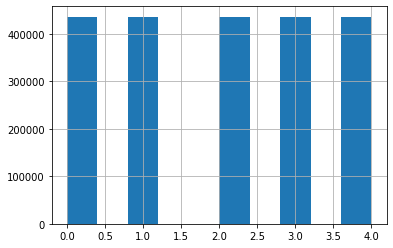

In [9]:
df_["ml_label"].hist()

In [10]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2182400 entries, 399 to 64590
Data columns (total 98 columns):
 #   Column               Dtype  
---  ------               -----  
 0   ml_smadiff_3         float32
 1   ml_maxdiff_3         float32
 2   ml_mindiff_3         float32
 3   ml_std_3             float32
 4   ml_ma_3              float32
 5   ml_volmaxdiff_3      float32
 6   ml_volmindiff_3      float32
 7   ml_volsmadiff_3      float32
 8   ml_volstd_3          float32
 9   ml_volma_3           float32
 10  ml_smadiff_5         float32
 11  ml_maxdiff_5         float32
 12  ml_mindiff_5         float32
 13  ml_std_5             float32
 14  ml_ma_5              float32
 15  ml_volmaxdiff_5      float32
 16  ml_volmindiff_5      float32
 17  ml_volsmadiff_5      float32
 18  ml_volstd_5          float32
 19  ml_volma_5           float32
 20  ml_smadiff_9         float32
 21  ml_maxdiff_9         float32
 22  ml_mindiff_9         float32
 23  ml_std_9             float32
 24

In [14]:
# Unload dataset after EDA to save memory
free_mem(df_)

# [-Start Training-]

In [5]:
with wandb.init(project=module.config.name) as run:
    trainer = TradingTrainer()
    container = trainer.fit(module, run, True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jliberooo (use `wandb login --relogin` to force relogin)


freqtrade.ml.trainer - Validating model using mini training...
Num train datas: 99563
Num val datas: 4617
Start Training...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6059279	test: 1.6064446	best: 1.6064446 (0)	total: 17.8ms	remaining: 160ms
9:	learn: 1.5791128	test: 1.5883714	best: 1.5883714 (9)	total: 155ms	remaining: 0us
bestTest = 1.588371397
bestIteration = 9
Accuracy: 0.27
freqtrade.ml.container - Not dropping X columns in predict because it doesn't exist in predict columns
freqtrade.ml.container - Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']

PASSED: The model passed the validation test!
freqtrade.ml.trainer - Validate model OK!
Num train datas: 1933552
Num val datas: 248848


Start Training...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6078956	test: 1.6081344	best: 1.6081344 (0)	total: 41.3ms	remaining: 8m 16s
250:	learn: 1.5423957	test: 1.5662603	best: 1.5662603 (250)	total: 10.8s	remaining: 8m 23s
500:	learn: 1.5368040	test: 1.5637801	best: 1.5637801 (500)	total: 21.6s	remaining: 8m 15s
750:	learn: 1.5337922	test: 1.5625510	best: 1.5625476 (747)	total: 32.3s	remaining: 8m 4s
1000:	learn: 1.5314551	test: 1.5617721	best: 1.5617691 (999)	total: 43.1s	remaining: 7m 54s
1250:	learn: 1.5295357	test: 1.5612593	best: 1.5612593 (1250)	total: 54s	remaining: 7m 43s
1500:	learn: 1.5278537	test: 1.5608992	best: 1.5608992 (1500)	total: 1m 4s	remaining: 7m 32s
1750:	learn: 1.5263397	test: 1.5606417	best: 1.5606414 (1749)	total: 1m 15s	remaining: 7m 21s
2000:	learn: 1.5249236	test: 1.5604528	best: 1.5604516 (1999)	total: 1m 26s	remaining: 7m 10s
2250:	learn: 1.5236003	test: 1.5602935	best: 1.5602935 (2250)	total: 1m 36s	remaining: 6m 59s
2500:	learn: 1.5223528	test: 1.5601602	best: 1.5601602 (2500)	total: 1m 47s	remain

wandb: Adding directory to artifact (c:\CS\Python\crypto-collection\freqtrade\superft\.temp\lightning_15n30-catboost_l2_2021-09-02_16-01-20)... Done. 0.1s


# Predictions EDA

In [5]:
# Validate prediction function by simulate inserting freqtrade data into predict function
df_val_preds = trainer.validate_predict(container)
df_val_preds

freqtrade.ml.container - Not dropping X columns in predict because it doesn't exist in predict columns


INFO:freqtrade.ml.container:Not dropping X columns in predict because it doesn't exist in predict columns


freqtrade.ml.container - Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']


INFO:freqtrade.ml.container:Returned new columns from df_preds: ['ml_0', 'ml_1', 'ml_2', 'ml_3', 'ml_4']



Dataset: Binance BTC/USDT 15m iloc[-10000:] (Freqtrade Regularized)


DF WITH PREDICTIONS INFO
----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 131026 to 141025
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    10000 non-null  datetime64[ns, UTC]
 1   open    10000 non-null  float64            
 2   high    10000 non-null  float64            
 3   low     10000 non-null  float64            
 4   close   10000 non-null  float64            
 5   volume  10000 non-null  float64            
 6   ml_0    9998 non-null   float64            
 7   ml_1    9998 non-null   float64            
 8   ml_2    9998 non-null   float64            
 9   ml_3    9998 non-null   float64            
 10  ml_4    9998 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(10)
memory usage: 937.5 KB
None


DF Original
----------
                            date      open  

,date,open,high,low,close,volume,ml_0,ml_1,ml_2,ml_3,ml_4
131026,2021-05-13 00:30:00+00:00,49711.83,50630.00,49578.94,49896.61,5110.913916,0.163629,0.163629,0.163628,0.175082,0.334032
131027,2021-05-13 00:45:00+00:00,49896.15,50324.72,49581.44,49666.99,2389.969100,0.163499,0.163499,0.163498,0.173767,0.335738
131028,2021-05-13 01:00:00+00:00,49661.12,50600.00,49305.43,50191.47,3869.211034,0.333124,0.176003,0.163624,0.163624,0.163624
131029,2021-05-13 01:15:00+00:00,50191.47,50437.86,49972.44,50324.12,2755.398561,0.165340,0.165340,0.167072,0.269613,0.232636
131030,2021-05-13 01:30:00+00:00,50314.99,50374.48,49665.94,49889.82,2116.566505,0.163499,0.163499,0.163498,0.173767,0.335738
...,...,...,...,...,...,...,...,...,...,...,...
141021,2021-08-25 03:15:00+00:00,48135.89,48274.85,48117.73,48250.65,211.447645,0.333124,0.176003,0.163624,0.163624,0.163624
141022,2021-08-25 03:30:00+00:00,48250.65,48275.00,48132.05,48191.09,194.839454,0.163916,0.189612,0.316306,0.166248,0.163918
141023,2021-08-25 03:45:00+00:00,48191.08,48248.23,47965.00,47975.93,344.786940,0.163456,0.169008,0.336713,0.167368,0.163455
141024,2021-08-25 04:00:00+00:00,47975.93,48245.00,47940.02,48155.56,275.930495,NaN,NaN,NaN,NaN,NaN


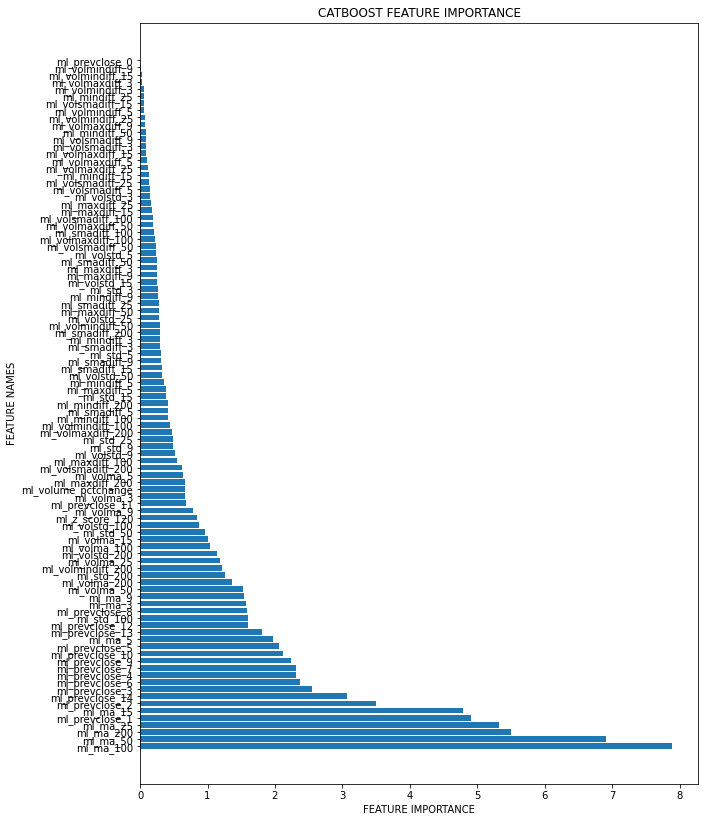

In [6]:
def plot_feature_importance(importance,names,model_type):
    import matplotlib.pyplot as plt
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,14))
    #Plot Searborn bar chart
    plt.barh(width=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(container.module.model.get_feature_importance(), container.config.columns_x, 'CATBOOST')

# Quick Takeaway from "15n30-catboost_l2"
- Model version: v0
- Mini training: False

Val uses last 2 months of TrainVal. Very good results in Model x Strategy Optimization using strategy below.

Strategy buy when:
- Close above 200 EMA
- Argmax is ml_4
- ml_4 > 0.6

But not good in Unbiased Testing phase.

Conclusion:
- Training using data to the present may affect performance in forward test
- Performance degraded when tested with data that is distant from trainval data

# Backtesting: Model Validation

Populating Indicators:   0%|          | 0/60 [00:00<?, ?it/s]

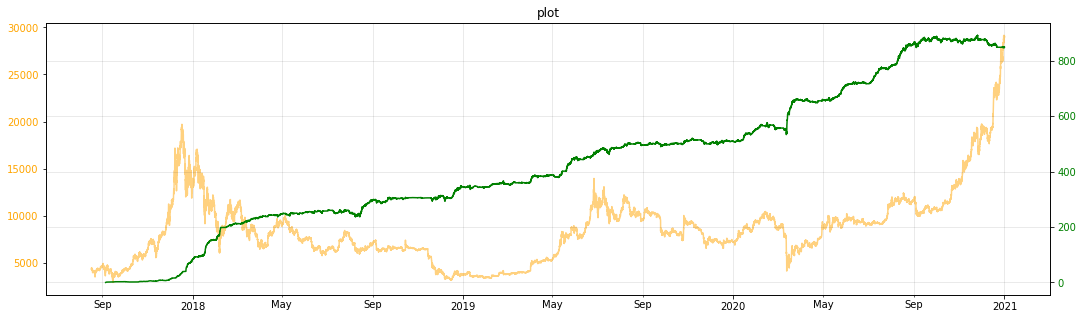

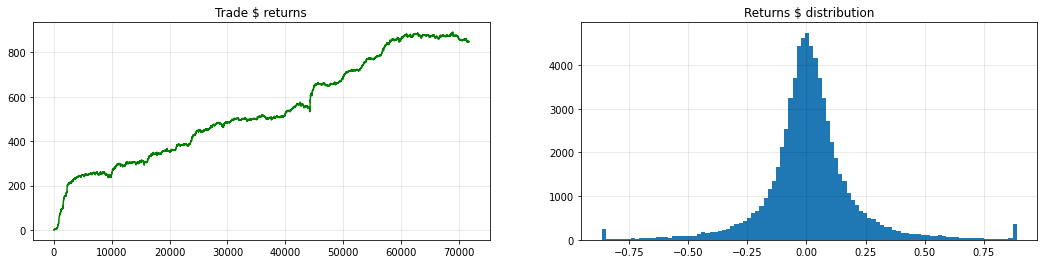

,Portfolio Summary
Trades,71701
Avg. Stake Amount,15.0
Number of Pairs,60
Min Balance,0.15
Max Balance,890.68
Final Balance,849.27
-,-
Wins,37550
Loses,34151
Win Rate,52.37%


In [6]:
"""
This strategy will backtested in Train and Validation date.
To make sure the model was fitted correctly, you need to know that you model is predicting accurately in this date.
Create the strategy that BUYS when the ML Model predicts the future is going to UP, and do the same for the sell.
The strategy doesn't need to be trend following, but the final backtest results must profitable steadily.

TIP: High threshold no trendline |OR| Low threshold with trendline
"""

def val_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="[|VERSION|]")        
    tp = str(int(lightning_container.config.timeframe.replace("m", "")) * lightning_container.config.num_future_candles)

    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {tp: -1}
        stoploss = -999
        startup_candle_count: int = 500
                    
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe = lightning_container.predict(dataframe)
            num_classes = lightning_container.config.num_classification_classes
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                dataframe["argmax_ml"] == "ml_4",
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
                        
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1

            return dataframe
    """ End Strategy Code """


MODEL_NAME = "15n30-catboost_l2"
MODEL_VER = "v0"

stats, summary, preset = start_backtesting(val_strategy, MODEL_NAME, "val", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)

# Backtesting: Strategy Optimization

Populating Indicators:   0%|          | 0/60 [00:00<?, ?it/s]

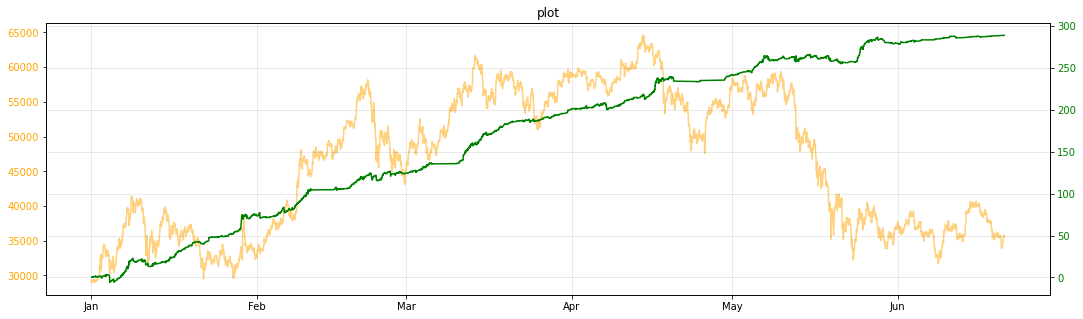

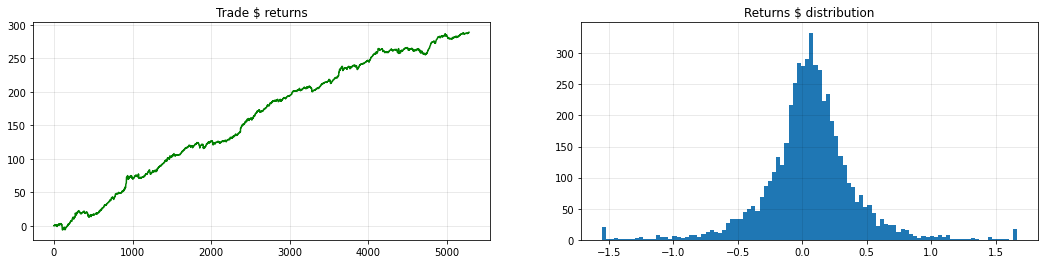

,Portfolio Summary
Trades,5284
Avg. Stake Amount,15.0
Number of Pairs,60
Min Balance,-5.96
Max Balance,288.79
Final Balance,288.79
-,-
Wins,3181
Loses,2103
Win Rate,60.2%


In [7]:
"""
Phase where you can trial and error, plug and play model with any strategy, until get the best results.
In this phase, feel free to combine the trained model with a variety of technical indicators or ensemble with another model.
"""

def opt_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="[|VERSION|]")        
    tp = str(int(lightning_container.config.timeframe.replace("m", "")) * lightning_container.config.num_future_candles)
    
    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {tp: -1}
        stoploss = -0.99
        startup_candle_count: int = 500
        
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe["ema"] = ta.EMA(dataframe, timeperiod=200)
            dataframe = lightning_container.predict(dataframe)
            
            num_classes = lightning_container.config.num_classification_classes
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                dataframe['close'] > dataframe['ema'],
                dataframe['argmax_ml'] == "ml_4",
                dataframe['ml_4'] > 0.5,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1
            return dataframe
    """ End Strategy Code """


stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "opt", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)

# Backtesting: Final Phase

Populating Indicators:   0%|          | 0/60 [00:00<?, ?it/s]

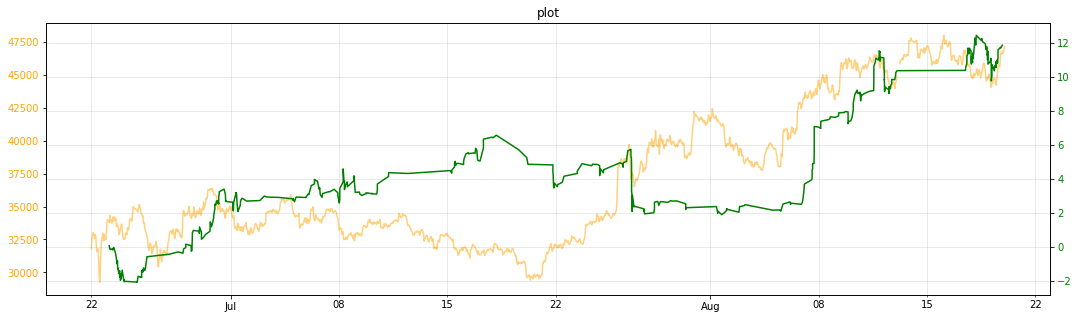

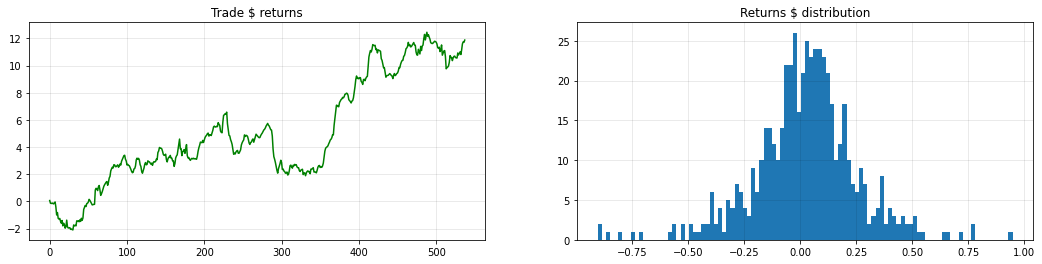

,Portfolio Summary
Trades,538
Avg. Stake Amount,15.0
Number of Pairs,57
Min Balance,-2.1
Max Balance,12.46
Final Balance,11.88
-,-
Wins,307
Loses,231
Win Rate,57.06%


In [8]:
"""
This is a phase where you believe your strategy is now optimized with your model.
This is not trial and error phase, and you can only run this phase ONCE every "good" optimized strategy to avoid biased results.
"""
stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "test", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)